<a href="https://colab.research.google.com/github/himsgpt/GenAI_agents/blob/main/langgraph_prompt_automate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install langgraph langchain-core pydantic
!pip install python-dotenv
!pip install fireworks-ai

In [ ]:
from typing import List, TypedDict
from pydantic import BaseModel
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.runnables import RunnableLambda
from langgraph.checkpoint.memory import InMemorySaver
from fireworks.client import Fireworks

In [ ]:
# --------------------------
# 1. Define promptdesign model
# --------------------------

class promptdesign(BaseModel):
    topic: str
    variables: List[str]
    negative_prompt: str
    output_format: str

# --------------------------
# 2. Define LangGraph state type
# --------------------------

class State(TypedDict):
    spec: promptdesign
    messages: List

def llm_call(chat_messages: List[dict]) -> HumanMessage:

  # Initialize client
  api_key="fw_3ZaUhoBEKrVjoowPYn8SzEDn"
  client = Fireworks(api_key=api_key)
  response = client.chat.completions.create(
    model="accounts/fireworks/models/mixtral-8x22b-instruct",
    messages=chat_messages,
    max_tokens=1024,
    temperature=0.1
  )
  ai_response = response.choices[0].message.content
  ai_msg = HumanMessage(content = ai_response)
  client.close()

  return ai_msg

# --------------------------
# 3. Nodes
# --------------------------

def info_node(state: State) -> State:
    """Build system and human messages from promptdesign input"""
    spec = state["spec"]

    system_msg = SystemMessage(
        content=f"You are a prompt engineering assistant. Your task is to design structured prompts for tasks like '{spec.topic}'."
    )

    human_msg = HumanMessage(
        content=(
            f"Design a prompt for: {spec.topic}\n\n"
            f"Required variables: {', '.join(spec.variables)}\n"
            f"Negative instruction: {spec.negative_prompt}\n"
            f"Desired output format: {spec.output_format}"
        )
    )

    return {
        "spec": spec,
        "messages": [system_msg, human_msg],
    }

def add_tool_message(state: State) -> State:
    """Adds a tool message acknowledgment"""
    last_msg = state["messages"][-1]
    tool_msg = ToolMessage(
        content="Acknowledged. Building your prompt now.",
        tool_call_id="tool_123"
    )
    return {
        "spec": state["spec"],
        "messages": state["messages"] + [tool_msg],
    }

def build_prompt(state: State) -> State:
    """Build a ChatPromptTemplate from messages"""
    prompt = ChatPromptTemplate.from_messages(
        state["messages"] + [MessagesPlaceholder(variable_name="history")]
    )
    messages = [
    {"role": "system", "content": m.content} if isinstance(m, SystemMessage)
    else {"role": "user", "content": m.content}
    for m in state["messages"]
    if not isinstance(m, ToolMessage)  # ✅ filter out ToolMessage
    ]
    ai_msg = llm_call(messages)
    return {"spec": state["spec"], "messages": state["messages"] + [ai_msg]}


def final_output(state: State) -> State:
    print("\n✅ LLM Generated Prompt:")
    print(state["messages"][-1].content)
    return state

def decide(state: State) -> str:
    return "call_llm" if any(isinstance(m, ToolMessage) for m in state["messages"]) else "add_tool_msg"


In [ ]:
memory = InMemorySaver()
workflow = StateGraph(State)

workflow.add_node("info", RunnableLambda(info_node))
workflow.add_node("add_tool_msg", RunnableLambda(add_tool_message))
workflow.add_node("call_llm", RunnableLambda(build_prompt))
workflow.add_node("final", RunnableLambda(final_output))

workflow.add_conditional_edges("info", decide, {"add_tool_msg": "add_tool_msg", "call_llm": "call_llm"})
workflow.add_edge("add_tool_msg", "call_llm")
workflow.add_edge("call_llm", "final")
workflow.add_edge("final", END)
workflow.add_edge(START, "info")

graph = workflow.compile(checkpointer=memory)

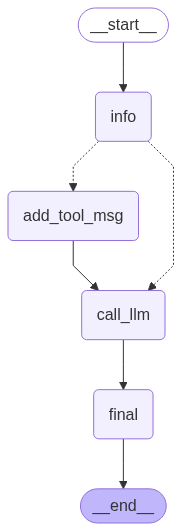

In [ ]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

## Invoke

In [ ]:
spec = promptdesign(
    topic="RAG pipeline",
    variables=["context", "question"],
    negative_prompt="irrelevant details",
    output_format="bullet points"
)
graph.invoke({"spec": spec, "messages": []}, config={"configurable": {"thread_id": "thread_1"}})

ERROR:asyncio:Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x7efb027041d0>
ERROR:asyncio:Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x7efb02833a90>



✅ LLM Generated Prompt:
Title: RAG Pipeline Task

Description:
You are given a context and a question. Your task is to extract relevant information from the context and provide a concise answer to the question using bullet points. Avoid including irrelevant details in your response.

Context: [Insert context here]

Question: [Insert question here]

Desired Output Format:
- Bullet point 1: [Relevant information from context]
- Bullet point 2: [Relevant information from context]
- Bullet point 3: [Relevant information from context]
- ...

Example:
Context: The RAG pipeline is a machine learning model that combines retrieval-augmented generation with a language model. It consists of three main components: a retriever, a reader, and a generator. The retriever fetches relevant documents from a large corpus, the reader extracts information from these documents, and the generator produces the final output based on the extracted information.

Question: What are the main components of the RAG 

{'spec': promptdesign(topic='RAG pipeline', variables=['context', 'question'], negative_prompt='irrelevant details', output_format='bullet points'),
 'messages': [SystemMessage(content="You are a prompt engineering assistant. Your task is to design structured prompts for tasks like 'RAG pipeline'.", additional_kwargs={}, response_metadata={}),
  HumanMessage(content='Design a prompt for: RAG pipeline\n\nRequired variables: context, question\nNegative instruction: irrelevant details\nDesired output format: bullet points', additional_kwargs={}, response_metadata={}),
  ToolMessage(content='Acknowledged. Building your prompt now.', tool_call_id='tool_123'),
  HumanMessage(content='Title: RAG Pipeline Task\n\nDescription:\nYou are given a context and a question. Your task is to extract relevant information from the context and provide a concise answer to the question using bullet points. Avoid including irrelevant details in your response.\n\nContext: [Insert context here]\n\nQuestion: [In

## Part 2: Self optimzation prompt

### ➕ Nodes:
init_node – sets initial prompt_text from spec, runs reward eval.

`generate_variants` – produces multiple prompt variants using the LLM.
`evaluate_variants` – runs each variant on sample input(s), obtains metric feedback.
`select_best` – re-ranks and picks the best-performing prompt variant.
`feedback_refine` – uses LLM-generated critiques (“textual gradients”) to refine best prompt.
`termination_check` – stops when performance plateaus or max iterations reached.
`final_output` – returns the optimized prompt.

In [9]:
import random
from typing import List, TypedDict
from pydantic import BaseModel
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import InMemorySaver
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_core.runnables import RunnableLambda
from fireworks.client import Fireworks

# --------------------------
# 1. Define promptdesign model
# --------------------------

class PromptDesign(BaseModel):
    topic: str
    variables: List[str]
    negative_prompt: str
    output_format: str
    num_variants: int = 2
    max_iters: int = 1

# --------------------------
# 2. Define LangGraph state type
# --------------------------

class State(TypedDict):
    spec: PromptDesign
    prompt_text: str
    performance: float
    iterations: int
    variants: List[str] # Added variants to state type
    scores: List[float] # Added scores to state type


# --------------------------
# 3. Helper: LLM call
# --------------------------

def llm_call(prompts: List[dict], model: str = "accounts/fireworks/models/mixtral-8x22b-instruct") -> str:
    client = Fireworks(api_key="fw_3ZaUhoBEKrVjoowPYn8SzEDn")
    try:
        resp = client.chat.completions.create(
            model=model,
            messages=prompts,
            max_tokens=200,
            temperature=0.7
        )
        if not resp.choices:
            raise ValueError("Fireworks API returned an empty list of choices.")
        content = resp.choices[0].message.content
        if not content:
            raise ValueError("Fireworks API returned None or empty content.")
        return content
    except Exception as e:
        print(f"Error during Fireworks API call: {e}")
        # Fallback
        return "Variation 1: [Default]\nVariation 2: [Default]"
    finally:
        client.close()



# --------------------------
# 4. Nodes
# --------------------------

def init_node(state: State) -> State:
    spec = state["spec"]
    # build initial prompt
    prompt = f"Task: {spec.topic}\nVariables: {', '.join(spec.variables)}\nFormat: {spec.output_format}"
    # evaluate initial via dummy
    initial_perf = 0.0
    return {"spec": spec, "prompt_text": prompt, "performance": initial_perf, "iterations": 0, "variants": [], "scores": []} # Initialized variants and scores

def generate_variants(state: State) -> State:
    spec = state["spec"]
    # create LLM prompt
    system = {"role": "system", "content": f"Generate {spec.num_variants} variations of this prompt: {state['prompt_text']}"}
    user = {"role": "user", "content": state["prompt_text"]}
    content = llm_call([system, user])
    # parse variants split by newline
    variants = [v.strip() for v in content.split("\n") if v.strip()]
    state["variants"] = variants
    return state

def evaluate_variants(state: State) -> State:
    # dummy scoring: random
    scores = [random.random() for _ in state["variants"]]
    state["scores"] = scores
    return state

def select_best(state: State) -> State:
    idx = max(range(len(state["variants"])), key=lambda i: state["scores"][i])
    best = state["variants"][idx]
    best_score = state["scores"][idx]
    state["prompt_text"] = best
    state["performance"] = best_score
    return state

def feedback_refine(state: State) -> State:
    # ask LLM to refine
    system = {"role": "system", "content": "Provide a refined version of the following prompt to improve clarity and effectiveness."}
    user = {"role": "user", "content": state["prompt_text"]}
    refined = llm_call([system, user])
    state["prompt_text"] = refined
    state["iterations"] += 1
    return state

def termination_check(state: State) -> bool:
    spec = state["spec"]
    # stop if reached max or performance plateau (random threshold)
    return state["iterations"] >= spec.max_iters

def final_output(state: State) -> State:
    print(f"\nFinal optimized prompt after {state['iterations']} iterations (score={state['performance']:.3f}):\n")
    print(state["prompt_text"])
    return state

# --------------------------
# 5. Build Graph
# --------------------------

memory = InMemorySaver()
workflow = StateGraph(State)

workflow.add_node("init", RunnableLambda(init_node))
workflow.add_node("gen", RunnableLambda(generate_variants))
workflow.add_node("eval", RunnableLambda(evaluate_variants))
workflow.add_node("select", RunnableLambda(select_best))
workflow.add_node("feedback", RunnableLambda(feedback_refine))
workflow.add_node("final", RunnableLambda(final_output))

# Edges: START -> init -> gen -> eval -> select -> feedback -> [loop or final]
workflow.add_edge(START, "init")
workflow.add_edge("init", "gen")
workflow.add_edge("gen", "eval")
workflow.add_edge("eval", "select")
workflow.add_edge("select", "feedback")
workflow.add_conditional_edges("feedback", lambda s: "final" if termination_check(s) else "gen", {"final": "final", "gen": "gen"})
workflow.add_edge("final", END)

graph = workflow.compile(checkpointer=memory)

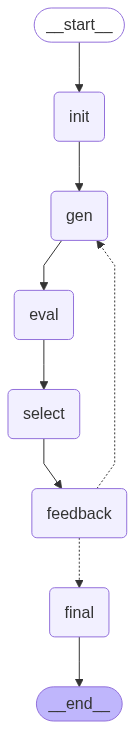

In [ ]:

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [10]:
# --------------------------
# 6. Run Example
# --------------------------

spec = PromptDesign(
    topic="Summarization",
    variables=["text"],
    negative_prompt="redundancy",
    output_format="concise paragraph",
    num_variants=3,
    max_iters=1
)

result = graph.invoke({"spec": spec, "prompt_text": "", "performance": 0.5, "iterations": 1},
             {"configurable": {"thread_id": "opt1"}})

for key, value in result.items():
  print(key, '\n', ': ', value)

ERROR:asyncio:Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x7f355d279e10>
ERROR:asyncio:Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x7f355f2d43d0>
ERROR:asyncio:Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x7f355d2cac90>
ERROR:asyncio:Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x7f355d2c9c90>



Final optimized prompt after 1 iterations (score=0.882):

Subject: Enhancing Clarity and Effectiveness of Given Text

Objective: Revise the provided text to ensure clarity, coherence, and improved effectiveness.

Original Text: [Insert original text here]

Refined Version: [Insert your revised and enhanced version of the given text here]

Explanation: [Detailed explanation of the changes made and how they improve the original text's clarity and effectiveness]

Notes:
1. Ensure the refined version maintains the original message and intent.
2. Consider the target audience, purpose, and context of the original text.
3. Prioritize conciseness, simplicity, and active voice to make the text more engaging and understandable.
4. Evaluate the tone and language to ensure they are appropriate for the context and audience.
5. Use proper grammar, punctuation, and sentence structure to improve readability.
6. Break down complex
spec 
 :  topic='Summarization' variables=['text'] negative_prompt='red

spec 
 :  topic='Summarization' variables=['text'] negative_prompt='redundancy' output_format='concise paragraph' num_variants=3 max_iters=1
prompt_text 
 :  Variation 1: [Default]
Variation 2: [Default]
performance 
 :  0.18231931496014087
iterations 
 :  1
variants 
 :  ['Variation 1: [Default]', 'Variation 2: [Default]']
scores 
 :  [0.18231931496014087, 0.1589645010342794]


In [ ]:
## Now LLM provider check

In [8]:
import os
import requests
from dotenv import load_dotenv

# Load API key
# load_dotenv(".env")
# api_key = os.getenv("FIREWORKS_API_KEY")
api_key="fw_3ZaUhoBEKrVjoowPYn8SzEDn"
print(f"API Key loaded: {bool(api_key)}")

# Test the actual chat completions endpoint
url = "https://api.fireworks.ai/inference/v1/models"
headers = {
    "Authorization": f"Bearer {api_key}",
    "Content-Type": "application/json",
}

try:
    response = requests.get(url, headers=headers)
    print(f"API Test Status Code: {response.status_code}")

    if response.status_code == 200:
        print("Connection successful! Available models:")
        models = [model['id'] for model in response.json()['data']]
        for model in models:
            print(f" - {model}")
    elif response.status_code == 401:
        print("Error: Invalid API Key. Please verify your Fireworks API key.")
    else:
        print(f"Unexpected response: {response.text}")

except Exception as e:
    print(f"Connection failed: {str(e)}")
    print("Possible issues:")
    print("1. Internet connectivity problem")
    print("2. Fireworks API service outage")
    print("3. Firewall blocking requests to fireworks.ai")

API Key loaded: True
API Test Status Code: 200
Connection successful! Available models:
 - accounts/perplexity/models/r1-1776
 - accounts/fireworks/models/flux-1-dev-fp8
 - accounts/fireworks/models/llama4-scout-instruct-basic
 - accounts/fireworks/models/llama4-maverick-instruct-basic
 - accounts/fireworks/models/llama-v3p1-8b-instruct
 - accounts/fireworks/models/llama-v3p1-405b-instruct
 - accounts/fireworks/models/mixtral-8x22b-instruct
 - accounts/fireworks/models/flux-kontext-max
 - accounts/fireworks/models/qwen3-coder-480b-a35b-instruct
 - accounts/fireworks/models/qwen3-235b-a22b-instruct-2507
 - accounts/fireworks/models/deepseek-r1-0528
 - accounts/fireworks/models/deepseek-r1-basic
 - accounts/fireworks/models/llama-v3p1-70b-instruct
 - accounts/fireworks/models/llama-v3p3-70b-instruct
 - accounts/fireworks/models/deepseek-r1
 - accounts/fireworks/models/qwen3-30b-a3b
 - accounts/fireworks/models/qwen3-coder-30b-a3b-instruct
 - accounts/fireworks/models/qwen3-30b-a3b-thinki